In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 50
X_size = 10000

X = np.linspace(0, 10, X_size)
X = X.reshape(-1,1)

# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)  # Generate sub_size evenly spaced indices.
# random_indices = np.random.choice(len(X), size = sub_size, replace=False)  # Randomly Select Index
# sorted_indices = np.sort(random_indices)

X_sub = X[sorted_indices]

def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 10 # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup)  # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)      #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)     # Kernel Matrix Generated from the Total Sample Set and Subsample Sets

K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                 # Feature Functions of the Sample Set

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

X_diag = np.diag(X.flatten())  # Sample Set Diagonal Matrix
X_sub_diag = np.diag(X_sub.flatten())  # Subsample Diagonal Matrix
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                                # First-Order Derivative of the Sample Set Feature Function

gamma = 10000000  #Hyperparameter: gamma

# Differential equation parameters
r = 0 * np.sin(X)
p = 1
E = np.eye(sub_size)
I = np.ones((X_size, 1))
f = -1

A = (gamma * (2 * X_F - X_F_D)).T
B = (gamma * f * I).T
zero = np.zeros((sub_size, 1))

# Construct the matrix equation and solve it.
X11 = E + f * A @ X_F - A @ X_F_D - f * A @ I @ X_F_1
X12 = X_F_1.T
X13 = zero
X1 = np.hstack((X11, X12, X13))
X21 = f * B @ X_F - B @ X_F_D -f * B @ I @ X_F_1
X22 = (np.array([1])).reshape(1, 1)
X23 = (np.array([0])).reshape(1, 1)
X2 = np.hstack((X21, X22, X23))
X31 = X_F_1
X32 = (np.array([0])).reshape(1, 1)
X33 = (np.array([1])).reshape(1, 1)
X3 = np.hstack((X31, X32, X33))

X_solve = np.vstack((X1, X2, X3))

Y1 = -A @ r - f * p * A @ I  
Y2 = -B @ r - f * p * B @ I
Y3 = (np.array([1])).reshape(1, 1)

Y_solve = np.vstack((Y1, Y2, Y3))
W_lam_b = np.linalg.solve(X_solve, Y_solve)

W = W_lam_b[:sub_size, :]
b = W_lam_b[-1]

#Calculate the prediction results.
y_p = np.real(np.dot(X_F,W) + b.item())

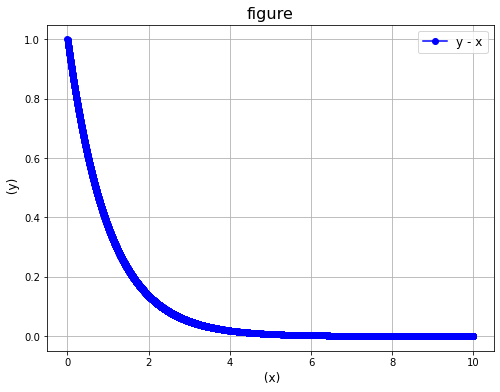

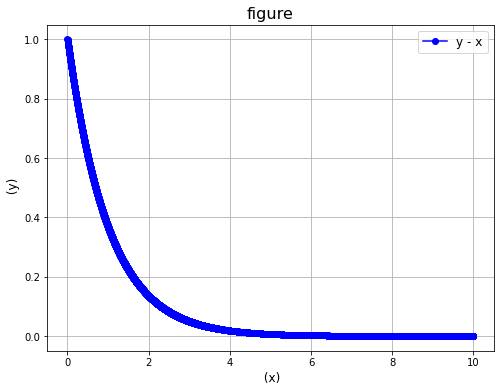

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#graph of the predicted values
x = X 
y = y_p              
a = y_p
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

#graph of the true values
x = X 
y_t = np.exp(-x)
y_t = np.array(y_t)
y = y_t               
b=y
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true)
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true)
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true, squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)

print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 

R2_fsvm: 0.9999999996452117, mae_fsvm: 3.1590113121547776e-06, rmse_fsvm: 3.7689523416909663e-06, inf_norm_fsvm: 9.749329698410802e-06


In [8]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})

data_to_save.to_csv('fsvm_02.csv', index=False)
print("fsvm_02.csv")

数据已保存至 fsvm_02.csv
